### Problem Description

This dataset consists of reviews of fine foods from amazon. The data span a period of more than 10 years, including all ~500,000 reviews up to October 2012. Reviews include product and user information, ratings, and a plain text review. It also includes reviews from all other Amazon categories.
### link: https://www.kaggle.com/snap/amazon-fine-food-reviews?select=Reviews.csv

### Import Packages

In [40]:
# Add environment Packages paths to conda
import os, sys
# env_name = "food_review"
# sys.path.append(f"C:\\Environments\\{env_name}\\lib\\site-packages\\")

import pandas as pd
import numpy as np

# Text preprocessing packages
import nltk # Text libarary
#nltk.download('stopwords')
import string # Removing special characters {#, @, ...}
import re # Regex Package
from nltk.corpus import stopwords # Stopwords
from nltk.stem import SnowballStemmer, WordNetLemmatizer # Stemmer & Lemmatizer
from gensim.utils import simple_preprocess  # Text ==> List of Tokens

# Text Embedding
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix

# Modelling
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Saving Model
import pickle

# Visualization Packages
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(font_scale=1.3)
%matplotlib inline

### Read Dataset

In [41]:
%%time
df = pd.read_csv('Reviews.csv')

Wall time: 3.19 s


In [42]:
f"{df.shape[0]:,} Review"

'568,454 Review'

In [43]:
cols = ['Text', 'Score']
df_text = df[cols].copy()
df_text.head()


,Text,Score
0,I have bought several of the Vitality canned d...,5
1,Product arrived labeled as Jumbo Salted Peanut...,1
2,This is a confection that has been around a fe...,4
3,If you are looking for the secret ingredient i...,2
4,Great taffy at a great price. There was a wid...,5


### Drop Duplicates
Save the Cleaned data-frame also with the variable `df_text`

In [44]:
## Write your code here
df_text = df_text.drop_duplicates()


### Target Variable Pre-Processing
`target` will be 
 - 0 if score < 3 
 - 1 otherwise
 


In [45]:
df_text['target']=df_text.Score.apply(lambda x: 0 if x<3 else 1)
df_text.head()

,Text,Score,target
0,I have bought several of the Vitality canned d...,5,1
1,Product arrived labeled as Jumbo Salted Peanut...,1,0
2,This is a confection that has been around a fe...,4,1
3,If you are looking for the secret ingredient i...,2,0
4,Great taffy at a great price. There was a wid...,5,1


#### Plot Countplot for target Variable

<AxesSubplot:xlabel='target', ylabel='count'>

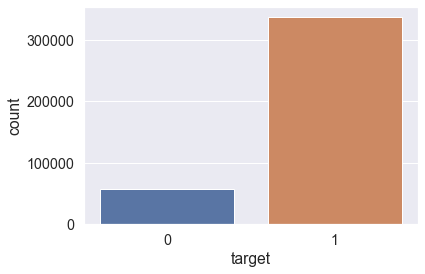

In [46]:
sns.countplot(x = df_text['target'])

Notice how such variance is huge ...   
Then we need to down-sample such data ... by which both the positive and negative classes are balanced.

### Balance Data Target

In [47]:
df_text = df_text.reset_index(drop=True)

In [48]:
# Sample from positive reviews Same number of negative reviews
NEG_N = df_text.target.value_counts()[0]
df_pos = df_text[df_text['target'] == 1]['Text'].sample(NEG_N, replace=False)
df_text_balanced = pd.concat([df_text.iloc[df_pos.index], df_text[df_text.target == 0]])


<AxesSubplot:xlabel='target', ylabel='count'>

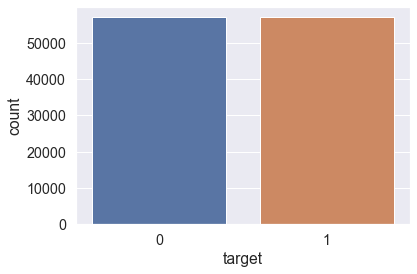

In [49]:
## PLot the target again after balancing
sns.countplot(x = df_text_balanced['target'])

### Text Pre-Processing

In [50]:
stop_words = set(stopwords.words('english'))
stemmer = SnowballStemmer("english")
lemmatizer= WordNetLemmatizer()

In [51]:
print(stop_words.remove('not'))
#stop_words

None


In [52]:
## Clean your reviews using stemmer, lemmatizer & stopword
df_text_balanced['Text'] = df_text_balanced['Text'].str.lower()
df_text_balanced['Text'] = df_text_balanced['Text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))
df_text_balanced["Text"] = df_text_balanced["Text"].str.replace('[^\w\s]','')
df_text_balanced.head()

D:\anaaaaacondaaa\envs\myenv\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  after removing the cwd from sys.path.


,Text,Score,target
125601,wonderful tasting coffee first hestitant pucha...,5,1
159452,believe worked not like magic increase supply ...,4,1
213440,fine fine california bay leaf stays wonderfull...,5,1
43867,husband ordered advice dr oz promoting healthy...,4,1
14210,nto like coffee dark taste brother loves swear...,4,1


In [53]:
df_text_balanced['split'] = df_text_balanced['Text'].str.split()


In [54]:
df_text_balanced['limmatize'] = df_text_balanced['split'].apply(lambda x: [lemmatizer.lemmatize(y) for y in x])

In [55]:
df_text_balanced['stemmer'] = df_text_balanced['limmatize'].apply(lambda x: [stemmer.stem(y) for y in x])
df_text_balanced.head()

,Text,Score,target,split,limmatize,stemmer
125601,wonderful tasting coffee first hestitant pucha...,5,1,"[wonderful, tasting, coffee, first, hestitant,...","[wonderful, tasting, coffee, first, hestitant,...","[wonder, tast, coffe, first, hestit, puchas, c..."
159452,believe worked not like magic increase supply ...,4,1,"[believe, worked, not, like, magic, increase, ...","[believe, worked, not, like, magic, increase, ...","[believ, work, not, like, magic, increas, supp..."
213440,fine fine california bay leaf stays wonderfull...,5,1,"[fine, fine, california, bay, leaf, stays, won...","[fine, fine, california, bay, leaf, stay, wond...","[fine, fine, california, bay, leaf, stay, wond..."
43867,husband ordered advice dr oz promoting healthy...,4,1,"[husband, ordered, advice, dr, oz, promoting, ...","[husband, ordered, advice, dr, oz, promoting, ...","[husband, order, advic, dr, oz, promot, health..."
14210,nto like coffee dark taste brother loves swear...,4,1,"[nto, like, coffee, dark, taste, brother, love...","[nto, like, coffee, dark, taste, brother, love...","[nto, like, coffe, dark, tast, brother, love, ..."


In [56]:
df_text_balanced.drop(['limmatize','split','Text'], axis='columns', inplace=True)


In [57]:
df_text_balanced.head()

,Score,target,stemmer
125601,5,1,"[wonder, tast, coffe, first, hestit, puchas, c..."
159452,4,1,"[believ, work, not, like, magic, increas, supp..."
213440,5,1,"[fine, fine, california, bay, leaf, stay, wond..."
43867,4,1,"[husband, order, advic, dr, oz, promot, health..."
14210,4,1,"[nto, like, coffe, dark, tast, brother, love, ..."


In [58]:
df_text_balanced['stemmer'] = df_text_balanced['stemmer'].apply(lambda x: ' '.join([word for word in x]))
df_text_balanced.head()

,Score,target,stemmer
125601,5,1,wonder tast coffe first hestit puchas coffe ch...
159452,4,1,believ work not like magic increas suppli stru...
213440,5,1,fine fine california bay leaf stay wonder arom...
43867,4,1,husband order advic dr oz promot healthi lifes...
14210,4,1,nto like coffe dark tast brother love swear gr...


### Split Test & Training Data

In [59]:
X = df_text_balanced.iloc[:,2].values
y = df_text_balanced.iloc[:,1].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train.shape, X_test.shape

((79917,), (34251,))

### Text Embedding
 - Use `TfidfVectorizer`
 - `fit` on the training data only
 - `transform` on training and test 

In [60]:
## TFIDF embedding for the Description
vectorizer = TfidfVectorizer()
# fit on training (such vectorizer will be saved for deployment)
vectorizer_tfidf=vectorizer.fit(X_train)
# transform on training data
X_train=vectorizer.transform(X_train)
# transform on testing data
X_test = vectorizer.transform(X_test)

In [61]:
# See the dimensions of your data embeddings before entering to the model
X_train.shape, X_test.shape

((79917, 75604), (34251, 75604))

### Modelling

In [62]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

##### Sklearn framework steps
 - init
 - fit
 - predict

In [63]:
## initialize your Model
clf = RandomForestClassifier(n_jobs=6)
# Fit your Model on the Training Dataset
clf.fit(X_train,y_train)
# Predict on Test data
preds = clf.predict(X_test)
# Calculate Model Accuracy
acc = accuracy_score(preds, y_test)
print(f"Model Accuracy = {round(acc*100,2)}%")

Model Accuracy = 84.52%


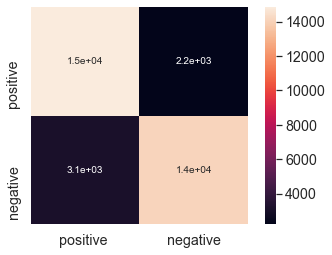

In [64]:
cm = confusion_matrix(y_test,preds)
class_names = ['positive ','negative']
df_cm = pd.DataFrame(cm, index = [i for i in class_names], columns = [i for i in class_names])
sns.heatmap(df_cm, annot = True)
cmap = plt.cm.Blues
plt.imshow(cm, interpolation = 'nearest', cmap = cmap)


### Raw Instance Prediction

In [65]:
def clean_review(text):
    stop_words = set(stopwords.words('english'))
    stop_words.remove('not')
    text = text.lower()
    text = text.replace('[^\w\s]', '')
    text = ' '.join([word for word in text.split() if word not in (stop_words)])
    lemmatizer = WordNetLemmatizer()
    text = text.split()
    text = ' '.join([lemmatizer.lemmatize(w) for w in text])
    stemmer = SnowballStemmer("english")
    text = text.split()
    text = ' '.join([stemmer.stem(w) for w in text])
    return text   


In [66]:
def raw_test(review, model, vectorizer):
    # Clean Review
    review = clean_review(review)
    review_c = review
    # Embed review using tf-idf vectorizer
    embedding = vectorizer.transform([review_c])
    # Predict using your model
    prediction = model.predict(embedding)
    # Return the Sentiment Prediction
    return "Positive" if prediction == 1 else "Negative"

In [67]:
review_1 = "That's a good Dish, Good Job"
review_2 = "That's the worst Dish ever tasted"


In [68]:
raw_test(review_1, clf, vectorizer_tfidf)

'Positive'

In [69]:
raw_test(review_2, clf, vectorizer_tfidf)

'Negative'

### Saving Models for Deployment

In [70]:
import pickle

In [71]:
model_name = 'rf_model.pk'
vectorizer_name = 'tfidf_vectorizer.pk'
model_path = os.path.join('/', model_name)
vect_path = os.path.join('/', vectorizer_name)
pickle.dump(clf, open(model_path, 'wb')) ## Save model
pickle.dump(vectorizer_tfidf, open(vect_path, "wb")) ## Save tfidf-vectorizer

### Load model Again and test them

In [72]:
loaded_model = pickle.load(open(model_path, 'rb'))
loaded_vect =  pickle.load(open(vect_path, 'rb'))

In [73]:
raw_test(review_1, loaded_model, loaded_vect)

'Positive'

In [74]:
raw_test(review_2, loaded_model, loaded_vect)

'Negative'

# Great Job !
### Now Deploy your ML model using Streamlit Framework

In [79]:
%%writefile Food_Review_Streamlit.py

import nltk # Text libarary
import pandas as pd
import numpy as np
import string # Removing special characters {#, @, ...}
import re # Regex Package
from nltk.corpus import stopwords # Stopwords
from nltk.stem import SnowballStemmer, WordNetLemmatizer # Stemmer & Lemmatizer
import pickle
import streamlit as st
from PIL import Image
import os, sys

model_path = 'C:/rf_model.pk'
vect_path = 'C:/tfidf_vectorizer.pk'
loaded_model = pickle.load(open(model_path, 'rb'))
loaded_vect =  pickle.load(open(vect_path, 'rb'))

def clean_review(text):
    stop_words = set(stopwords.words('english'))
    stop_words.remove('not')
    text = text.lower()
    text = text.replace('[^\w\s]', '')
    text = ' '.join([word for word in text.split() if word not in (stop_words)])
    lemmatizer = WordNetLemmatizer()
    text = text.split()
    text = ' '.join([lemmatizer.lemmatize(w) for w in text])
    stemmer = SnowballStemmer("english")
    text = text.split()
    text = ' '.join([stemmer.stem(w) for w in text])
    return text   


def raw_test(review, model, vectorizer):
    # Clean Review
    review = clean_review(review)
    review_c = review
    # Embed review using tf-idf vectorizer
    embedding = vectorizer.transform([review_c])
    # Predict using your model
    prediction = model.predict(embedding)
    # Return the Sentiment Prediction
    return "Positive" if prediction == 1 else "Negative"

def main():
      # web page title
    st.title("WElcome in Food review Prediction")
      
    html_temp = """
    <div style ="background-color:gray;padding:15px">
    <h1 style ="color:white;text-align:center;">Review prediction</h1>
    </div>
    """
    st.markdown(html_temp, unsafe_allow_html = True)
      
    # Take the text data 
    
    review = st.text_input("Enter your review to predict : ")
    x =""
    
    if st.button("Predict"):
        x = raw_test(review, loaded_model, loaded_vect)
    st.success('The prediction is {}'.format(x))
     
if __name__=='__main__':
    main()

Overwriting Food_Review_Streamlit.py


In [ ]:
!streamlit run Food_Review_Streamlit.py
